# Decoding Board from Data

In [84]:
#necessary imports
import pandas
import numpy as np
import os
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Input
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex = True)
import math

import matplotlib.pyplot as plt
%matplotlib inline

%run exp_Drivers.ipynb

EMPTY = 1;
COLOR = 0;

BLACK = -1;
WHITE = 1;

WIDTH = 9;

# Data Categorization and Assignment

In [43]:
Boards = []
Moves = []
def Main():
    path = "./go9"
    counter = 0
    for entry in os.scandir(path): #I changed my mind i love python
        Go = True
        Board = createEmptyBoard() # 0 - 80 = [color, empty], 81 = [turn, turn]
        with open(entry) as f:
            if Go:
                for line in f:
                    if line[0] == ';': # this is the line with all the moves.
                        Go = False
                        copy = ""
                        for c in line:
                            if c != "[" and c != "]" and c != ")":
                                copy += c
                        arr = copy[1:].split(';')
                        for a in arr:
                            int_move = Decode_Move(a[1:])
                            move = index_to_coordinate(int_move)
                            color = 1
                            if(a[0] == 'B'):
                                color = -1
                            Boards.append(Board)
                            Moves.append(int_move)
                            if int_move < 81:
                                Board = Move(Board, move[1], move[0])[1]
Main()
Boards = np.array(Boards)
print(Moves[0])
Moves = np.array(Moves)

40


In [44]:
print(Boards.shape)

(414124, 9, 9, 2)


In [76]:
# Example Position:
printBoard(Boards[22], -1)
printBoard(Boards[23], 1)

#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . O . @ . @ . .
4  . . . O @ @ O @ .
5  . . @ O @ O O @ .
6  . . O . @ O . . .
7  . . . . @ O . . .
8  . . . @ O O . . .
9  . . . . . . . . .

#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . O . @ . @ . .
4  . . . O @ @ O @ .
5  . . @ O @ O O @ .
6  . . O @ @ O . . .
7  . . . . @ O . . .
8  . . . @ O O . . .
9  . . . . . . . . .



In [46]:
X = Boards
Y = keras.utils.to_categorical(Moves)

training_samples = int(0.9 * X.shape[0])
X_train, X_test = X[:training_samples], X[training_samples:] # Inputs
Y_train, Y_test = Y[:training_samples], Y[training_samples:] # Outputs

print(X.shape)
print(Y.shape)
print(Moves)

(414124, 9, 9, 2)
(414124, 82)
[40 49 41 ... 75 18 36]


# Building the Model

In [64]:

model = keras.models.Sequential()

model.add(keras.layers.Dense(2, activation = 'relu', input_shape = (9, 9, 2)))
model.add(keras.layers.Conv2D(27, (3, 3), activation = 'relu'))
model.add(keras.layers.Conv2D(27, (3, 3), activation = 'relu'))
model.add(keras.layers.Conv2D(27, (3, 3), activation = 'relu'))
model.add(keras.layers.Conv2D(27, (3, 3), activation = 'relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation = 'relu'))
model.add(keras.layers.Dense(82, activation = 'softmax'))


model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics = [keras.metrics.CategoricalAccuracy()])
print(X_train.shape)

model.summary()

(372711, 9, 9, 2)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 9, 9, 2)           6         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 27)          513       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 5, 5, 27)          6588      
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 3, 3, 27)          6588      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 1, 1, 27)          6588      
_________________________________________________________________
flatten_9 (Flatten)          (None, 27)                0         
_________________________________________________________________
dense_32 (Dense)             (None,

# Training

In [65]:
# Load Weights
#model.load_weights('mini_weights.h5')

In [66]:
#Train the model
history = model.fit(X_train, Y_train, batch_size = 32, epochs = 16, workers = 10, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/16
11648/11648 [==============================] - 93s 8ms/step - loss: 3.9511 - categorical_accuracy: 0.0540 - val_loss: 3.6480 - val_categorical_accuracy: 0.1140
Epoch 2/16
11648/11648 [==============================] - 91s 8ms/step - loss: 3.5585 - categorical_accuracy: 0.1335 - val_loss: 3.4585 - val_categorical_accuracy: 0.1628
Epoch 3/16
11648/11648 [==============================] - 90s 8ms/step - loss: 3.3905 - categorical_accuracy: 0.1749 - val_loss: 3.3537 - val_categorical_accuracy: 0.1827
Epoch 4/16
11648/11648 [==============================] - 90s 8ms/step - loss: 3.3060 - categorical_accuracy: 0.1945 - val_loss: 3.3106 - val_categorical_accuracy: 0.1957
Epoch 5/16
11648/11648 [==============================] - 90s 8ms/step - loss: 3.2518 - categorical_accuracy: 0.2076 - val_loss: 3.2791 - val_categorical_accuracy: 0.2053
Epoch 6/16
11648/11648 [==============================] - 91s 8ms/step - loss: 3.2178 - categorical_accuracy: 0.2158 - val_loss: 3.2409 - val_cat

In [67]:
# Save Weights
model.save_weights('mini_weights.h5')

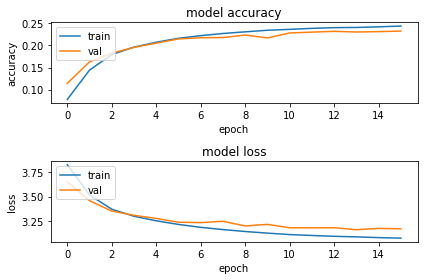

In [68]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [86]:
Play()